[*********************100%***********************]  10 of 10 completed



Optimal Weights for Each Instrument:
AAPL: 0.0468
MSFT: 0.0006
GOOGL: 0.0006
AMZN: 0.0005
TSLA: 0.0005
META: 0.0013
NVDA: 0.4990
JPM: 0.4490
UNH: 0.0008
V: 0.0008

Optimal Portfolio Return: 6.298351081247602e-07


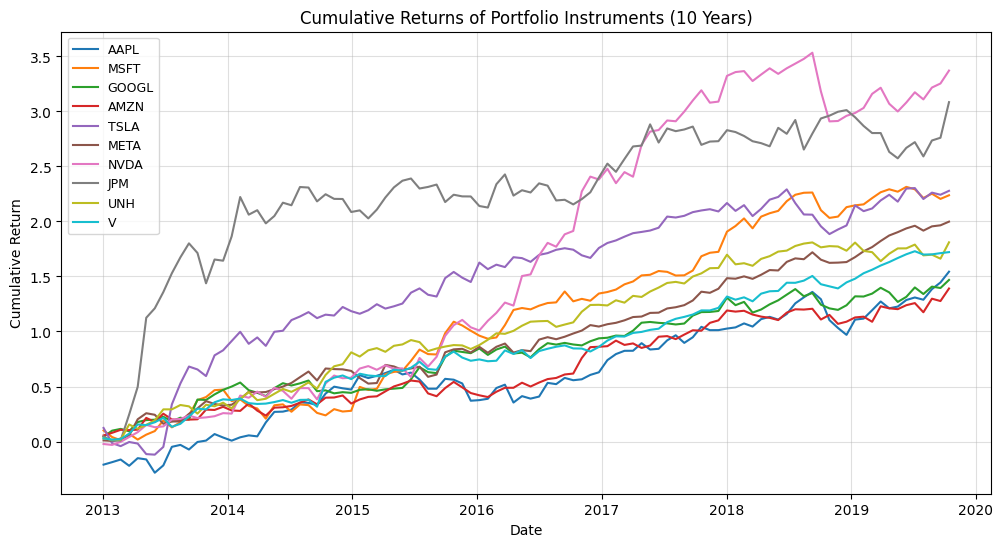

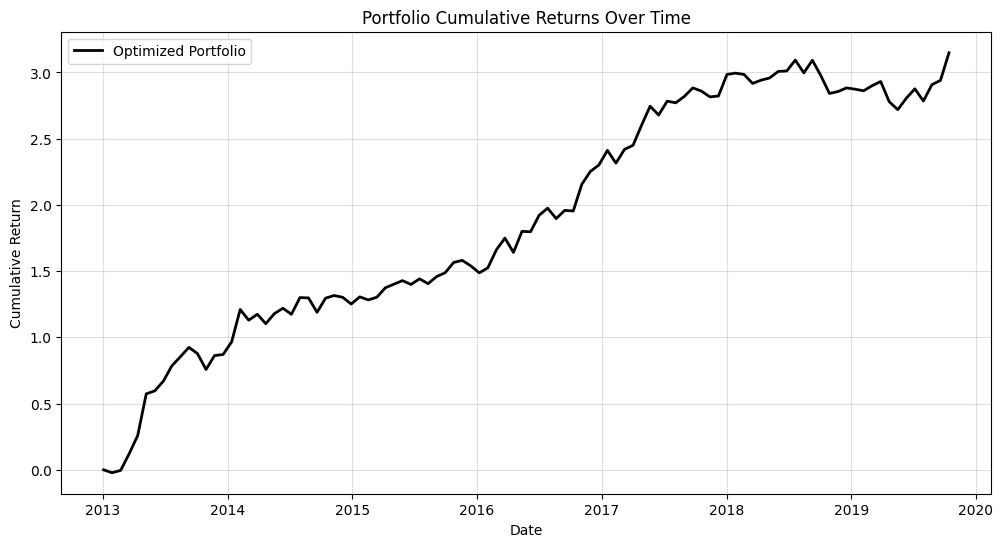

In [7]:
import yfinance as yf
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
d = 5  # 5 years duration for portfolio optimization
C = 1_000_000  # Portfolio capital: 10 lakh
alpha = 0.6  # Fraction of top drawdowns not considered
v = 0.2  # Fraction of Capital we can put at stake
N = 10 * 10  # Number of time samples (10 years, 10 samples per year)
m = 10  # Number of instruments in the portfolio

# Tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "JPM", "UNH", "V"]

# Fetch real data for 10 years
start_date = "2013-01-01"
end_date = "2023-01-01"
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")["Adj Close"]

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Resample to get N samples per year (10 samples per year, approximately every ~25 trading days)
resampled_returns = daily_returns.resample("25D").sum().iloc[:N]

# Calculate cumulative returns y(t) for each instrument
cumulative_returns = resampled_returns.cumsum()  # Shape: (N, m)

# Convert to numpy array
y = cumulative_returns.to_numpy()

# Constraints for portfolio weights
x_min = np.zeros(m)  # Minimum weight for each instrument
x_max = np.full(m, 0.5)  # Maximum weight for each instrument

# Decision variables
x = cp.Variable(m)
z = cp.Variable(N, nonneg=True)
u = cp.Variable(N)
zeta = cp.Variable()

# Constraints
constraints = []

# Constraint: ζ + (1 / (1-α)N) * sum(z) <= v3 * C
constraints.append(zeta + (1 / ((1 - alpha) * N)) * cp.sum(z) <= v3 * C)

# Constraints for z and u
for k in range(N):
    constraints.append(z[k] >= u[k] - cp.sum(cp.multiply(y[k], x)) - zeta)
    constraints.append(z[k] >= 0)
    constraints.append(u[k] >= cp.sum(cp.multiply(y[k], x)))
    if k > 0:
        constraints.append(u[k] >= u[k - 1])

constraints.append(u[0] == 0)

# New constraint: Sum of elements of x must equal 1
constraints.append(cp.sum(x) == 1)

# Constraints for bounds on portfolio weights
for i in range(m):
    constraints.append(x[i] >= x_min[i])
    constraints.append(x[i] <= x_max[i])

# Objective function: Maximize portfolio return
objective = cp.Maximize((1 / (d * C)) * cp.sum(cp.multiply(y[-1], x)))

# Problem definition and solving
problem = cp.Problem(objective, constraints)
problem.solve()

# Results
optimal_weights = x.value
print("\nOptimal Weights for Each Instrument:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.4f}")

print("\nOptimal Portfolio Return:", (cumulative_returns.iloc[-1] @ optimal_weights) / (d * C))

# Plot cumulative returns for individual instruments
plt.figure(figsize=(12, 6))
for i, ticker in enumerate(tickers):
    plt.plot(cumulative_returns.index, cumulative_returns.iloc[:, i], label=ticker)

plt.title("Cumulative Returns of Portfolio Instruments (10 Years)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=9)
plt.grid(alpha=0.4)
plt.show()

# Plot portfolio cumulative return
portfolio_cumulative_return = cumulative_returns @ optimal_weights
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, portfolio_cumulative_return, label="Optimized Portfolio", color="black", linewidth=2)

plt.title("Portfolio Cumulative Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=10)
plt.grid(alpha=0.4)
plt.show()


[*********************100%***********************]  4 of 4 completed


Weights (Drops/Dips-Conscious): [0.498363 0.       0.       0.501637]
Weights (Non-Tolerant): [7.77156117e-16 5.55111512e-17 0.00000000e+00 1.00000000e+00]


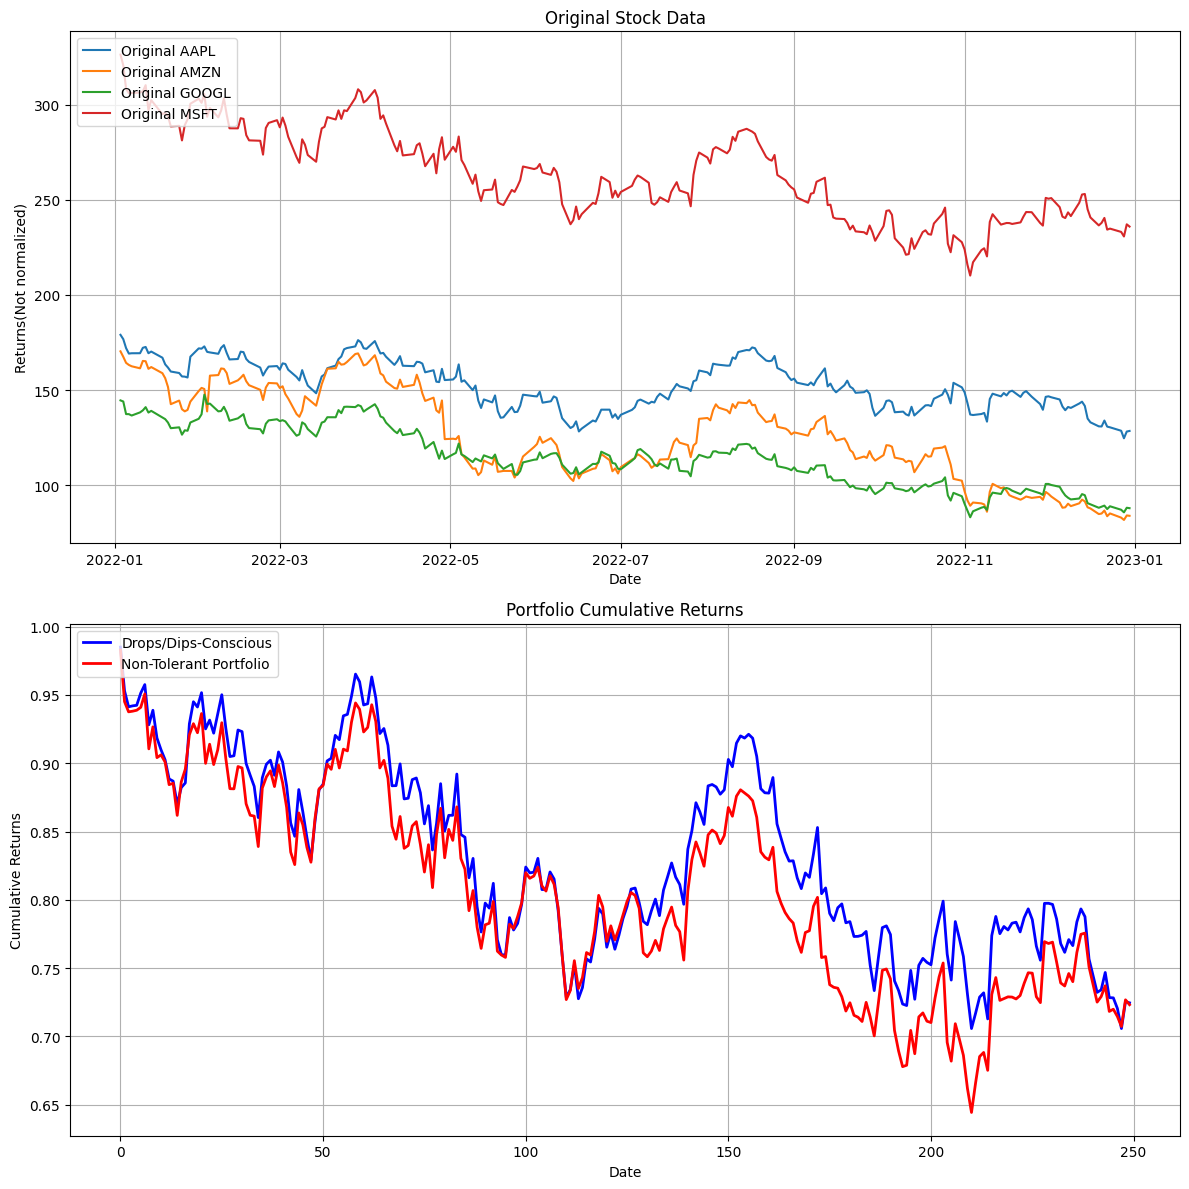

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Fetch stock data
def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

# Calculate drawdown
def calculate_drawdown(cumulative_returns):
    # Convert to Pandas Series if not already
    if isinstance(cumulative_returns, np.ndarray):
        cumulative_returns = pd.Series(cumulative_returns)
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Objective function for drawdown-conscious model
def negative_return_with_drawdown(weights, mean_returns, cov_matrix, historical_returns):
    weights = np.array(weights)
    p_returns = np.dot(weights, mean_returns)
    portfolio_returns = np.dot(historical_returns, weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    max_drawdown = calculate_drawdown(cumulative_returns)
    return -(p_returns - 0.1 * abs(max_drawdown))  # Penalize large drawdowns

# Objective function for non-tolerant model
def negative_return(weights, mean_returns, cov_matrix):
    weights = np.array(weights)
    p_returns = np.dot(weights, mean_returns)
    return -p_returns  # Focus only on maximizing returns

def optimize_portfolio(obj_func, mean_returns, cov_matrix, historical_returns=None):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights = 1
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling
    initial_weights = num_assets * [1.0 / num_assets]  # Equal weights initially

    # Check if historical_returns is required
    if historical_returns is not None:
        result = minimize(obj_func, initial_weights, args=(mean_returns, cov_matrix, historical_returns),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        result = minimize(obj_func, initial_weights, args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x


# Plot cumulative returns and original data on separate curves
def plot_cumulative_returns(data, weights_drawdown, weights_non_tolerant):
    historical_returns = data.pct_change().dropna()

    # Create figure for the plots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # Plot the original stock data
    for ticker in data.columns:
        axes[0].plot(data[ticker], label=f"Original {ticker}")
    axes[0].set_title("Original Stock Data")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Returns(Not normalized)")
    axes[0].legend(loc='upper left')
    axes[0].grid()

    # Drawdown-conscious portfolio
    portfolio_drawdown = np.dot(historical_returns, weights_drawdown)
    cumulative_drawdown = (1 + portfolio_drawdown).cumprod()

    # Non-tolerant portfolio
    portfolio_non_tolerant = np.dot(historical_returns, weights_non_tolerant)
    cumulative_non_tolerant = (1 + portfolio_non_tolerant).cumprod()

    # Plot cumulative returns of the portfolios
    axes[1].plot(cumulative_drawdown, label="Drops/Dips-Conscious",  color='b', linewidth=2)
    axes[1].plot(cumulative_non_tolerant, label="Non-Tolerant Portfolio",  color='r', linewidth=2)
    axes[1].set_title("Portfolio Cumulative Returns")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Cumulative Returns")
    axes[1].legend(loc='upper left')
    axes[1].grid()

    # Show the plot
    plt.tight_layout()
    plt.show()



# Main script
if __name__ == "__main__":
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
    start_date = '2022-01-01'
    end_date = '2023-01-01'

    # Fetch data
    data = get_stock_data(tickers, start_date, end_date)
    historical_returns = data.pct_change().dropna()
    mean_returns = historical_returns.mean() * 252
    cov_matrix = historical_returns.cov() * 252

    # Optimize portfolios
    weights_drawdown = optimize_portfolio(negative_return_with_drawdown, mean_returns, cov_matrix, historical_returns)
    weights_non_tolerant = optimize_portfolio(negative_return, mean_returns, cov_matrix)

    # Print weights
    print("Weights (Drops/Dips-Conscious):", weights_drawdown)
    print("Weights (Non-Tolerant):", weights_non_tolerant)

    # Plot cumulative returns
    plot_cumulative_returns(data, weights_drawdown, weights_non_tolerant)
